# Análisis de los bots que contestan preguntas

Para medir el comportamiento de los bots se han usado los mismos métodos para obtener las respuestas que en el juego, además las preguntas se obtienen de la base de datos de preguntas y respuestas; por último las respuestas se comprueban de la misma manera. Primero se mira si es la respuesta de la base de datos, si no lo es, se comprueba con la api de ChatGPT.

Se ha medido el comportamiento de los bots en las siguientes categorías:
- Nivel Fácil, Medio y Difícil
- **Respuestas correctas**: Se ha medido el porcentaje de respuestas correctas de los bots.
- **Tiempo de respuesta**: Se ha medido el tiempo que tardan los bots en responder.

Se espera que el "ProdigyBot" tenga un porcentaje de aciertos alto en todas las categorías, mientras que "MistakeBot" debería tener un porcentaje de aciertos bajo.

In [1]:
from pymongo import MongoClient
from openai import OpenAI
import os
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
load_dotenv()
apiKey = os.getenv("API_KEY")
client_openai = OpenAI(api_key=apiKey)

mongoKey = os.getenv("MONGODB_URIv2")

client = MongoClient(mongoKey)
db = client["el-rosco"]
collection = db["questions"]
size = 200

levels = ["Easy", "Medium", "Hard"]
categories = ["Not valid", "Incorrect"]

sizes_time = [100, 200, 300, 400, 500]

PRODIGY_BOT_DIR = "ft:gpt-3.5-turbo-0125:tfg:prodigy-bot:9K0x2IdL"
MISTAKE_BOT_DIR = "ft:gpt-3.5-turbo-0125:tfg:mistake-bot:9K37TYuv"

In [8]:
def get_questions():
	questions = {}

	for level in levels:
		questions_level = []
		cursor = collection.aggregate([
			{"$match": {"level": level}},
			{"$sample": {"size": size}}
		])
		
		for question in cursor:
			if question['word'][0].lower() == question['letter']:
				string = "Starts with "+ question['letter'] + ": " + question['description']
			else:
				string = "Contains "+ question['letter'] + ": " + question['description']
			questions_level.append((string, question['word']))
		questions.update({level: questions_level})
	return questions

def get_questions_time(size):
	questions = []

	cursor = collection.aggregate([
		{"$sample": {"size": size}}
	])
	
	for question in cursor:
		if question['word'][0].lower() == question['letter']:
			string = "Starts with "+ question['letter'] + ": " + question['description']
		else:
			string = "Contains "+ question['letter'] + ": " + question['description']
		questions.append((string, question['word']))
	return questions

def get_answer_time(model, questions):
	start_time = time.time()

	for question in questions:
		prompt = get_prodigy_prompt(question) if 'prodigy' in model else get_mistake_prompt(question)
		answer = client_openai.chat.completions.create(
			model=model,
			messages=[{"role": "user", "content": prompt}],
			max_tokens=50
		)
	elapsed_time = time.time() - start_time
	return elapsed_time

def valid_response_prompt(real_answer, poss_answer, definition):
    return f"Answer me only with 1 if yes and 2 if not: \n" \
           f"Definition: {definition}\n" \
           f"Word: {poss_answer}\n" \
           f"If the word doesn't exist just say 2.\n" \
           f"Does the word \"{poss_answer}\" match this definition \"{definition}\" entirely or is a synonym for the word {real_answer}?"


def verify_api_answer(real_answer, poss_answer, definition):
    prompt = valid_response_prompt(real_answer, poss_answer, definition)
    response = client_openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user","content": prompt}],
        temperature=0.5,
        max_tokens=2
    )	
    if response.choices[0].message.content == "1":
        return True
    return False

def verify_answer(answer, question):
    if answer.lower() == question[1].lower():
        return True
    elif verify_api_answer(question[1], answer, question[0]):
        return True
    return False

def valid_answer(answer, question):
	condition = question[0].split(":")[0]
	letter = condition.split(" ")[-1]
	if "Starts with" in condition:
		return answer[0].lower() == letter.lower()
	else:
		return answer.lower().find(letter.lower()) != -1

def get_prodigy_prompt(question):
    return f"Answer with only a real english word that starts with {question[0].split(':')[0]} and means: {question[0].split(':')[1]}"

def get_mistake_prompt(question):
    return f"Answer with only one word that is wrong for this description: {question}"

def get_answer_model(model, questions):
	correct_level ={
		"Easy": 0,
		"Medium": 0,
		"Hard": 0
	}
	incorrect_level ={
		"Easy":{
			"Not valid": 0,
			"Incorrect": 0
		},
		"Medium":{
			"Not valid": 0,
			"Incorrect": 0
		},
		"Hard":{
			"Not valid": 0,
			"Incorrect": 0
		}
	}	

	bot = "prodigy" if 'prodigy' in model else "mistake"

	for level in tqdm(questions, desc="Processing levels"):
		for question in questions[level]:
			prompt = get_prodigy_prompt(question) if bot == "prodigy" else get_mistake_prompt(question)
			answer = client_openai.chat.completions.create(
				model=model,
				messages=[{"role": "user", "content": prompt}],
				max_tokens=50
			)
			if valid_answer(answer.choices[0].message.content, question):
				if verify_answer(answer.choices[0].message.content, question):
					correct_level[level] += 1
				else:
					incorrect_level[level]["Incorrect"] += 1
			else:
				incorrect_level[level]["Not valid"] += 1
        
	return correct_level, incorrect_level

def generate_correct_chart(metrics_prodigy, metrics_mistake):
	levels = ["Easy", "Medium", "Hard"]
	bars_prodigy = [metrics_prodigy[nivel] for nivel in levels]
	bars_mistake = [metrics_mistake[nivel] for nivel in levels]

	plt.figure(figsize=(8, 4))
	bar_width = 0.35
	index = range(len(levels))
	plt.bar(index, bars_prodigy, bar_width, label='Prodigy Bot', color='dodgerblue')
	plt.bar([i + bar_width for i in index], bars_mistake, bar_width, label='Mistake Bot', color='red')
	plt.xlabel('Nivel')
	plt.ylabel('Respuestas Correctas (%)')
	plt.title('Respuestas Correctas por Nivel y Bot')
	plt.xticks([i + bar_width / 2 for i in index], levels)
	plt.legend()

	for i, (bar_prodigy, bar_mistake) in enumerate(zip(bars_prodigy, bars_mistake)):	
		plt.text(i, bar_prodigy + 1, f'{bar_prodigy}%', ha='center', color='black')
		plt.text(i + bar_width, bar_mistake + 1, f'{bar_mistake}%', ha='center', color='black')

	plt.tight_layout()


def generate_stacked_bar_chart(data, bot):
    levels = ["Easy", "Medium", "Hard"]
    categories = ["Not valid", "Incorrect"]
    categories_labels = ["No válidas", "Incorrectas"]

    fig, ax = plt.subplots(figsize=(6, 4))

    x = range(len(levels))
    width = 0.35

    for j, category in enumerate(categories):
        bars = [data[level][category] for level in levels]
        ax.bar([i + j * width for i in x], bars, width, label=categories_labels[j], color=['cornflowerblue', 'forestgreen'][j])

        for i, level in enumerate(levels):
            ax.text(i + (width * (j)), bars[i] + 0.5, f"{bars[i]}%", ha='center', va='bottom', color='black')

    ax.set_yticks(range(0, 101, 10))
    ax.set_xlabel('Nivel')
    ax.set_ylabel('Respuestas incorrectas (%)')
    ax.set_title('Respuestas incorrectas por nivel y categoría de ' + bot)
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(levels)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [4]:
questions = get_questions()
print(f"Easy questions: {len(questions['Easy'])}, medium questions: {len(questions['Medium'])}, hard questions: {len(questions['Hard'])}")

Easy questions: 200, medium questions: 200, hard questions: 200


In [5]:
print("Metrics for prodigy bot")
correct_prodigy, incorrect_prodigy = get_answer_model(PRODIGY_BOT_DIR, questions)

print("\nMetrics for mistake bot")
correct_mistake, incorrect_mistake = get_answer_model(MISTAKE_BOT_DIR, questions)

Metrics for prodigy bot


Processing levels: 100%|██████████| 3/3 [07:10<00:00, 143.36s/it]



Metrics for mistake bot


Processing levels: 100%|██████████| 3/3 [08:01<00:00, 160.51s/it]


In [6]:
for level in levels:
	correct_prodigy[level] = round((correct_prodigy[level] / size) * 100, 0)
	correct_mistake[level] = round((correct_mistake[level] / size) * 100, 0)
	for category in categories:
		incorrect_prodigy[level][category] = round((incorrect_prodigy[level][category] / size) * 100, 0)
		incorrect_mistake[level][category] = round((incorrect_mistake[level][category] / size) * 100, 0)

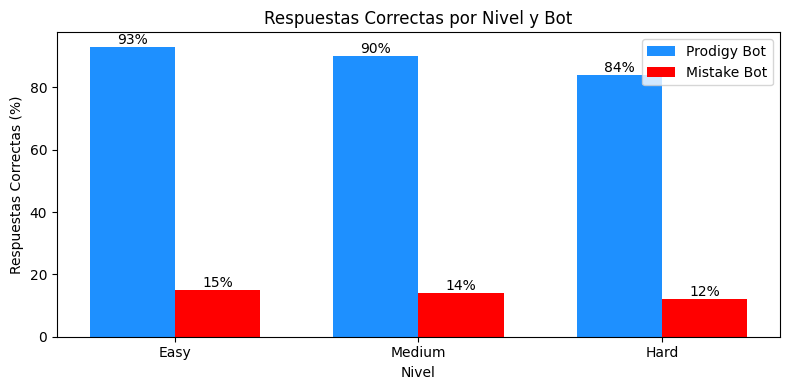

In [9]:
generate_correct_chart(correct_prodigy, correct_mistake)

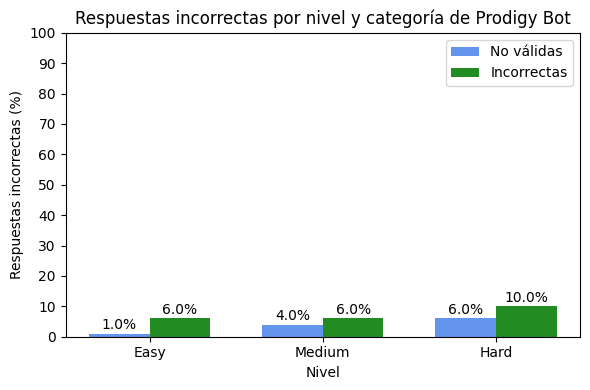

In [8]:
generate_stacked_bar_chart(incorrect_prodigy, "Prodigy Bot")

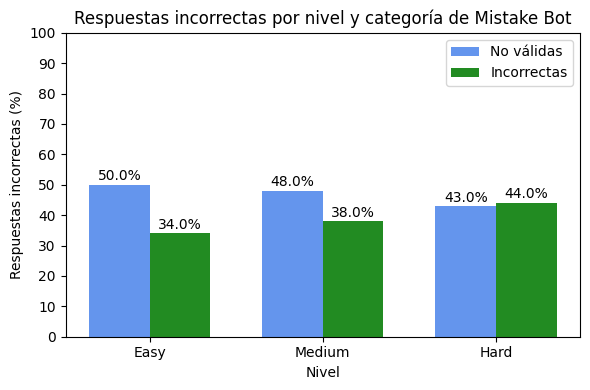

In [9]:
generate_stacked_bar_chart(incorrect_mistake, "Mistake Bot")

**Velocidad de respuesta:**

In [48]:
times_prodigy = []
times_mistake = []

for size in tqdm(sizes_time, desc="Processing sizes"):
	avg_time_prodigy = 0
	avg_time_mistake = 0
	for i in range(5):
		questions = get_questions_time(size)
		
		time_p = get_answer_time(PRODIGY_BOT_DIR, questions)
		avg_time_prodigy += time_p
		
		time_m = get_answer_time(MISTAKE_BOT_DIR, questions)
		avg_time_mistake += time_m

	times_prodigy.append(avg_time_prodigy / 10)
	times_mistake.append(avg_time_mistake / 10)	

Processing sizes: 100%|██████████| 5/5 [1:56:28<00:00, 1397.62s/it]


In [53]:
for i in range(len(sizes_time)):
	times_prodigy[i] = times_prodigy[i] * 2
	times_mistake[i] = times_mistake[i] * 2

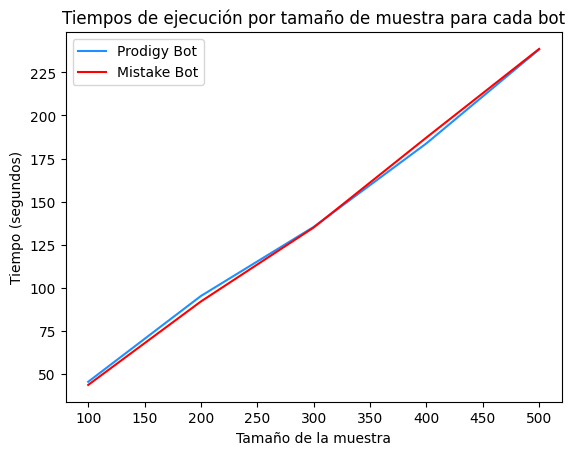

In [54]:
plt.plot(sizes_time, times_prodigy, label='Prodigy Bot',color='dodgerblue')
plt.plot(sizes_time, times_mistake, label='Mistake Bot',color='red')

plt.xlabel('Tamaño de la muestra')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempos de ejecución por tamaño de muestra para cada bot')
plt.legend() 